# Introduction to Machine Learning (CSCI-UA.473)

## Lab 3: Probability Review and Bayesian Linear Regression
### Date: September 23rd, 2021
### Name: (your name goes here)
### Email: (your NYU email goes here)

### Goal:  Demonstrate some of the concepts of probability in practice. In addition we also demonstrate how to implement Bayesian Linear Regression in practice.

The contents of this lab are adapted from Prof. Andrew Gordon Wilson's class and also from https://twiecki.io/blog/2013/08/12/bayesian-glms-1/ by Thomas Wiecki

# Probability Review

Machine Learning is all about dealing with uncertainties and stochasticity. The uncertainty could be inherent to the system we are working with, unobservability or just model inadequacy. Probability theory provides a formal framework to study these quantitatively.

**NOTE**: There are two major schools of thought on how to interpret probabilities. They differ in primarily how they interpret the probabilistic quantities. 
* Frequentist: a *frequentist* typically relies on interpreting counts 
* Bayesian: a *Bayesian* always speaks about "beliefs"

At the end of the day, both schools end up using the same formulas and hence most of the debate is futile. Beware of falling into this trap.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

## Random Variables

A variable which takes on values "randomly" is a random variable (*rv*). The exact definition of randomness is defined by either the probability mass function (*pmf*) for discrete variables or the probability density function (*pdf*) for continuous variables.

In principle, any discrete or continuous function can become a *pmf* or *pdf* as long as sums (integrates) to 1. The probability is always associated with a set (or more informally events).

### Bernoulli Distribution

A classic distribution which can model random variables that take on binary values (like a coin flip) is the Bernoulli Distribution $Bern(p)$ where $p$ is the probability of variable being 1. It is defined by

$$
P(X) = p^{X} \left(1-p\right) ^{1 - X}
$$

### Binomial Distribution

A natural extension of Bernoulli is the Binomial distribution $Binom(n,p)$ where we simply have $n$ independent Bernoulli trials with $k$ values being 1. The *pmf* is given by

$$
P(X = k) = \binom{n}{k} p^k \left(1-p\right) ^{n - k}
$$

We plot below the *pmf* for different values of $p$ and $10$ trials.

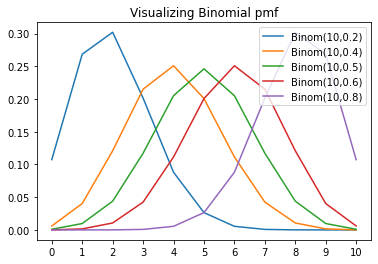

In [2]:
n = 10

for p in [0.2, 0.4, 0.5, 0.6, 0.8]:
    P = stats.binom(n, p)
    plt.plot(range(n + 1), [P.pmf(k) for k in range(n + 1)], label='Binom(10,{})'.format(p))

plt.title('Visualizing Binomial pmf')
plt.legend(loc='best')
plt.xticks(range(n + 1))
plt.show()

### Categorical and Multinomial Distribution

Naturally, we can define multi-category counterparts for both Bernoulli and Binomial distributions known as Categorical ($Cat(\mathbf{p})$) and Multinomial ($Multinomial(n, \mathbf{p})$) Distributions. The *pmf* of $n$ independent Categorical trials where $\mathbf{k}$ is vector defining the counts of each of the $K$ classes is given by

$$
P(\mathbf{X} = \mathbf{k}) = \dfrac{n!}{\prod_{i=1}^K \mathbf{k}_i!} \prod_{i=1}^K \mathbf{p}_i^{\mathbf{k}_i}
$$

Below, we sample from a uniform Categorical distribution (Multinomial distribution with $n=1$) 10 categories and plot a histogram in the end to see whether we achieve uniformity.

**TIP**: Try increasing the number of samples to see if you achieve uniformity in the number of samples (ideally they should get close).

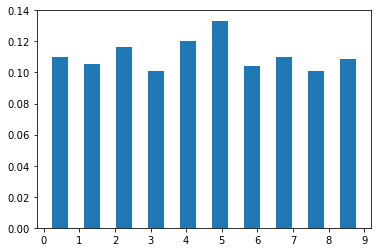

In [3]:
P = stats.multinomial(1, np.ones(10) / np.sum(np.ones(10)))

num_samples = 1000
samples = np.argmax(P.rvs(num_samples), axis=1)

plt.hist(samples, rwidth=0.5, density=True)
plt.xticks(range(10))
plt.show()

### Gaussian Distribution

This is one of the most used and most important distributions identified by a mean $\mu$ and variance $\Sigma$:  $\mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$. The *pdf* is given by

$$
f(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^k |\Sigma|}} \exp{\left(-\frac{1}{2} (\mathbf{x} - \mathbf{u})^T \Sigma^{-1} (\mathbf{x} - \mathbf{u}) \right) }
$$

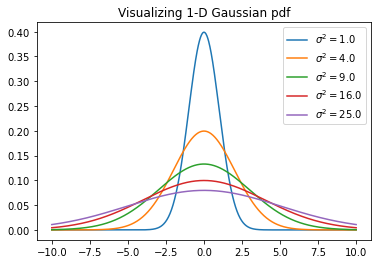

In [4]:
for sigma in np.linspace(1.0, 5.0, 5):
    P = stats.multivariate_normal(cov=sigma**2)
    plt.plot(np.linspace(-10, 10, 1000), P.pdf(np.linspace(-10, 10, 1000)), label='$\sigma^2={}$'.format(sigma**2))

plt.title('Visualizing 1-D Gaussian pdf')
plt.legend(loc='best')
plt.show()

Let us also see a contour plot of how a 2-D Gaussian centered at the zero vector would look like.

**NOTE**: Try playing around with the covariance matrix `cov` and see how the shape changes. Make sure it remains a positive definite matrix ($\det(\Sigma) \neq 0$).

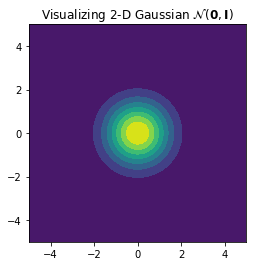

In [5]:
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
xv, yv = np.meshgrid(x, y)
xy = np.concatenate([np.expand_dims(xv, axis=-1), np.expand_dims(yv, axis=-1)], axis=-1)

P = stats.multivariate_normal(cov=np.eye(2))

plt.contourf(xv, yv, P.pdf(xy), cmap=plt.cm.viridis)
plt.title('Visualizing 2-D Gaussian $\mathcal{N}(\mathbf{0}, \mathbf{I})$')
plt.axis('square')
plt.show()

### Laplace Distribution

This is another important distribution from the exponential family which often finds its use as a prior to induce L1 regularization to a loss function. The *pdf* is given by

$$
f(x) = \frac{1}{2b} \exp{\left(-\frac{|x-\mu|}{b}\right)}
$$

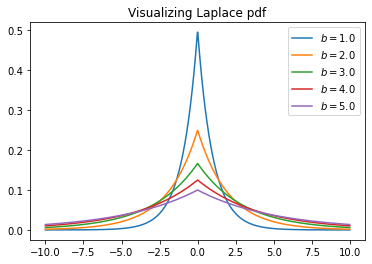

In [6]:
for b in np.linspace(1.0, 5.0, 5):
    P = stats.laplace(scale=b)
    plt.plot(np.linspace(-10, 10, 1000), P.pdf(np.linspace(-10, 10, 1000)), label='$b={}$'.format(b))

plt.title('Visualizing Laplace pdf')
plt.legend(loc='best')
plt.show()

One of the key ideas to understand with probability distributions in continuous spaces is that they operate on a volume (remember the idea that probability operates on a set). The following two questions rely on the same key concept and will help understand how a probability mass function is different from a probability density function.

* Consider a random variable $\mathbf{X} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$. What is $P(\mathbf{X}=\mathbf{0})$?

* Consider a 1-D Gaussian random variable $X \sim \mathcal{N}(0.0, 0.1)$. The density function of this distribution at the mean $f(X=0.0)$ evaluates to greater than 1.0. Probabilities should lie between zero and one. How do you justify that?

The answer to both these questions lies in the fact that **probabilities operate on volumes** (or sets in discrete domains). Hence, the density function needs to be multiplied by the mass to give out the correct probability. Hence, the correct mathematical formulation would be

$$
p(x) = f(x) dx
$$

for some differential mass $dx$. This missing $dx$ factor explains the second question. As a result, the probability of any point mass is $0$ because $dx \to 0$ and therefore $P(\mathbf{X}=\mathbf{0}) = 0$ in the first question.

## Sampling

Often times in practice, we are concerned with two things about a probability distribution - **density evaluation** and **sampling**. We've seen parts of density evaluation and now we will delve a little into sampling.

Sampling is loosely the process of building a representative set of values which follow the same underlying density. Each element in a data set is a "representative sample" from the same underlying distribution. We will take a look at a few basic sampling techniques.

### Inverse Transform Sampling

The core idea here is to use the inverse of cumulative density (or mass) function to get a sample. Consider a distribution whose cumulative density function is given by $\mathbf{F}_X(x)$. The steps involved are:

1. Generate a uniform random variable $u \sim \mathcal{U}(0, 1)$
2. Return the sample $x = \mathbf{F}^{-1}_X(u)$

A critical assumption here is that the function $\mathbf{F}_X$ is invertible and can be computed in closed form. Let us take a look at an example.

#### Sampling from the Exponential Distribution

The *pdf* of the exponential distribution is given by

$$
f(x) = \lambda \exp{\left(-\lambda x\right)}
$$

The *cdf* can be computed in closed form and is given by 
$$
F(x) = 1 - \exp{\left(-\lambda x\right)}
$$

Notice that $f(x) = \frac{\text{d}}{\text{d}x}F(x)$.

The inverse is also straightforward

$$
F^{-1}(u) = -\frac{1}{\lambda} \log{(1 - u)}
$$

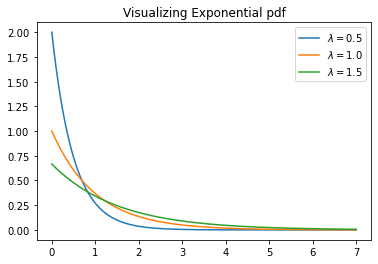

In [7]:
for l in [0.5, 1.0, 1.5]:
    P = stats.expon(scale=l)
    points = np.linspace(0, 7, 1000)
    plt.plot(points, P.pdf(points), label='$\lambda={}$'.format(l))


plt.title('Visualizing Exponential pdf')
plt.legend(loc='best')
plt.show()

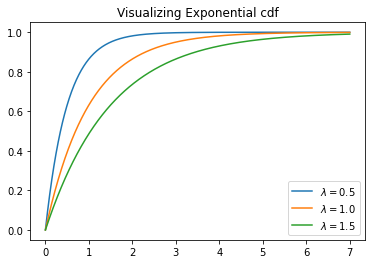

In [8]:
for l in [0.5, 1.0, 1.5]:
    P = stats.expon(scale=l)
    points = np.linspace(0, 7, 1000)
    plt.plot(points, P.cdf(points), label='$\lambda={}$'.format(l))

plt.title('Visualizing Exponential cdf')
plt.legend(loc='best')
plt.show()

Let us use inverse transform sampling and then plot a histogram to see whether we recover a shape as the exponential distribution for $\lambda=1$.

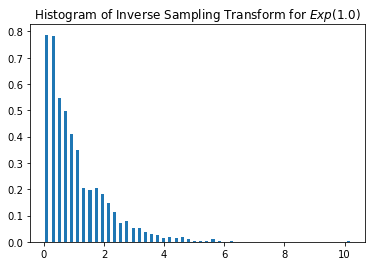

In [9]:
U = stats.uniform()
u = U.rvs(size=1000)
x = - np.log(1 - u)

plt.hist(x, bins=50, density=True, rwidth=0.5)
plt.title('Histogram of Inverse Sampling Transform for $Exp(1.0)$')
plt.show()

This technique is fairly basic and relies on very strong restrictions like known the *cdf* and being able to invert the same. Hence, for more real world examples where we often know *pdf* only uptil a normalizing factor and no closed form *cdf*, this technique fails.

### Sampling via Deterministic Transforms

Another important technique in sampling is to deterministically transform a random variable belonging to a known distribution. The probability distribution of the transformed random variable is given by the change of variables formula in probability.

$$
\mathbf{Z} \sim P_\mathbf{Z} \\
\mathbf{X} = T(\mathbf{Z}) \\
P_\mathbf{X}(\mathbf{x}) = P_\mathbf{Z}(\mathbf{z}) \left| \frac{\text{d}}{\text{d}\mathbf{x}} T^{-1}(\mathbf{z}) \right|
$$

Note that derivative term will be a Jacobian matrix whose determinant we take.

A classic technique to sample from a 2-D Standard Normal distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$ known as the **Box-Mueller** method uses this deterministic transform sampling technique.

Let $U, V \sim \mathcal{U}(0,1)$, we define $X = \sqrt{-2 \log{U}} \cos{2\pi V}$ and $Y = \sqrt{-2 \log{U}} \sin{2\pi V}$. Then $X,Y \sim \mathcal{N}(0, 1)$. Let us view this practically to see if we arrive at the right shape. Applying the above change of variable formula should show that this creates the Gaussian distribution.

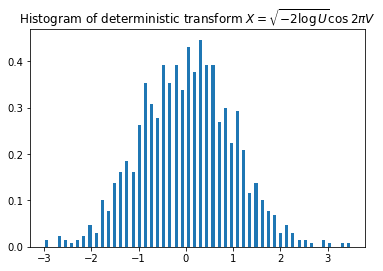

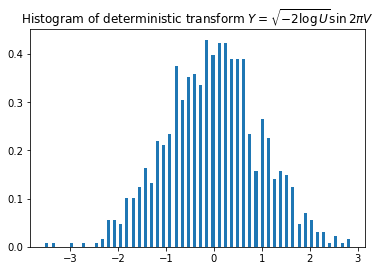

In [10]:
U, V = stats.uniform(), stats.uniform()
u, v = U.rvs(size=1000), V.rvs(size=1000)

x = np.sqrt(-2 * np.log(u)) * np.cos(2 * np.pi * v)
y = np.sqrt(-2 * np.log(u)) * np.sin(2 * np.pi * v)

plt.hist(x, bins=50, density=True, rwidth=0.5)
plt.title('Histogram of deterministic transform $X = \sqrt{-2 \log{U}} \cos{2\pi V}$')
plt.show()

plt.hist(y, bins=50, density=True, rwidth=0.5)
plt.title('Histogram of deterministic transform $Y = \sqrt{-2 \log{U}} \sin{2\pi V}$')
plt.show()

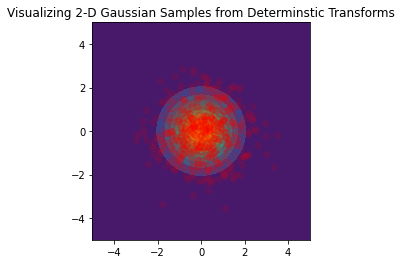

In [11]:
plt.contourf(xv, yv, stats.multivariate_normal(cov=np.eye(2)).pdf(xy), cmap=plt.cm.viridis)
plt.title('Visualizing 2-D Gaussian Samples from Determinstic Transforms')

plt.scatter(x, y, alpha=0.1, color='red')

plt.axis('square')
plt.show()

For higher dimensions, we can extend the above technique by using Cholesky decomposition and another deterministic transform.

# Bayesian Linear Regression

We will now demonstrate how Bayesian Machine Learning actually works in practice. We will work with one of the simplest models, namely the Bayesian version Linear Regression. 

## Linear Regression

In general, frequentists think about Linear Regression as follows:

$$
Y = \theta^T X + \epsilon
$$

where `𝑌` is the output we want to predict (or dependent variable), `𝑋` is our predictor (or independent variable), and $\theta$ are the coefficients (or parameters) of the model we want to estimate. 𝜖 is an error term which is assumed to be normally distributed.

We can then use Ordinary Least Squares or Maximum Likelihood to find the best fitting $\theta$.

## Probabilistic Reformulation

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be rewritten to yield:
$$
Y \sim \mathcal{N}(\theta^T X, \sigma^2)
$$

In words, we view `𝑌` as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

Now instead of getting model parameters as a single fixed vector, we aim to estimate *posterior* distribution of model paramters *given* the observed data:

$$p(\theta|D) = p(\theta|X,y)$$

Using the bayes formula:

$$p(\theta|X,y) = \frac{p(\theta,X,y)}{p(X,y)} = \frac{p(y|\theta,X)p(\theta|X)p(X)}{p(y|X)p(X)} = \frac{p(y|\theta,X)p(\theta|X)}{p(y|X)}$$

where $p(\theta|X)$ is a parameters prior distribution, $p(y|\theta,X)$ is a likelihood of the data outputs given the parameters and $p(\theta|X,y)$ is a posterior distribution of the parameters given the observed data.

We have already defined the likelihood to be univariate normal.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

* Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.

* Quantifying uncertainty: We do not get a single estimate of $\theta$ but instead a complete posterior distribution about how likely different values of $\theta$ are. For example, with few data points our uncertainty in $\theta$ will be very high and we’d be getting very wide posteriors.


Let us first import the required modules. In particular we will import the package PyMC3 which allows us to do probabilistic programing in Python. 

In [12]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3 import *

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


## Generating data

We will create some toy data to play around with and plot it. Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [13]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

data = dict(x=x, y=y)

Now lets plot it and see what it look like. 

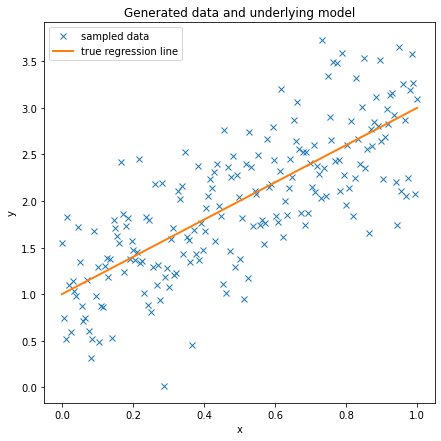

In [14]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Building the model

We now fit a Bayesian linear regression model to this data. As you can see, model specifications in PyMC3 are wrapped in a with statement.

In [15]:
with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement

    # Define the priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("Intercept", 0, sigma=20)
    x_coeff = Normal("x", 0, sigma=20)

    # Define the likelihood function (which we know is a Normal distribution)
    likelihood = Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=y)

    # Inference
    trace = sample(3000, cores=2)  # draw 3000 posterior samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 6 seconds.


## Analyzing the model

Bayesian inference does not give us only one best fitting line (as maximum likelihood does) but rather a whole posterior distribution of likely parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

/home/jkker/miniconda3/envs/ml/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/tmp/ipykernel_16142/3824871689.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


<Figure size 504x504 with 0 Axes>

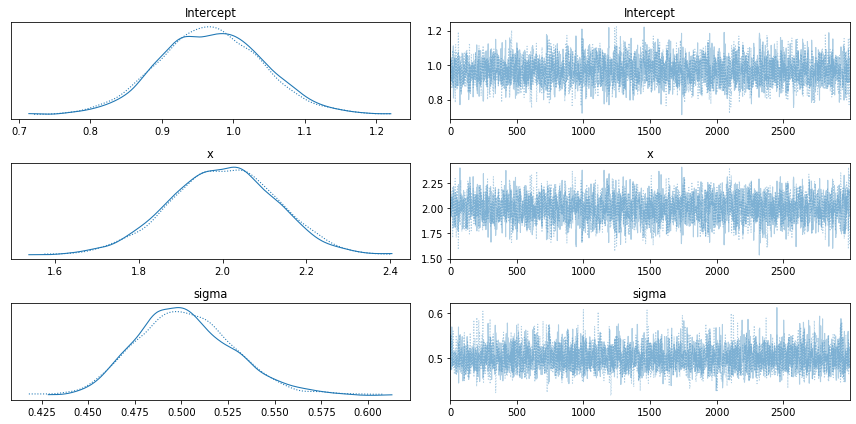

In [16]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

The left side shows our marginal posterior – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).

In the GLM we thus do not only have one best fitting regression line, but many. 

### Plot Posterior Regression Lines

A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. Here we are using the `plot_posterior_predictive_glm()` convenience function for this.

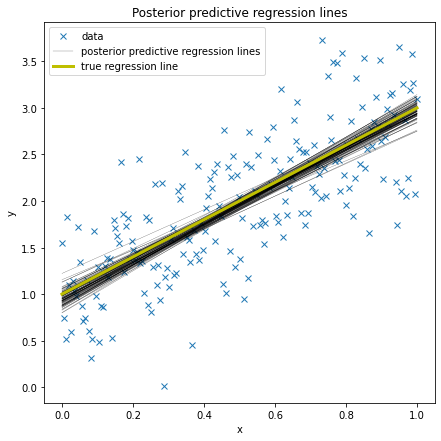

In [17]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "x", label="data")
plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");